# Import thư viện


In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
from xgboost import XGBClassifier
from xgboost import plot_importance

# Load data

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [4]:
!kaggle datasets download -d henriqueyamahata/bank-marketing
!unzip bank-marketing.zip


Dataset URL: https://www.kaggle.com/datasets/henriqueyamahata/bank-marketing
License(s): other
  0% 0.00/393k [00:00<?, ?B/s]
100% 393k/393k [00:00<00:00, 642MB/s]
Archive:  bank-marketing.zip
  inflating: bank-additional-full.csv  
  inflating: bank-additional-names.txt  


In [5]:
bank_marketing = pd.read_csv('/content/bank-additional-full.csv', sep=';')
bank_marketing.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


# Data cleaning


In [6]:
df = bank_marketing.copy()

In [7]:
df.duplicated().sum()


np.int64(12)

In [8]:
df = df.drop_duplicates()


In [9]:
df.isnull().sum()


,0
age,0
job,0
marital,0
education,0
default,0
housing,0
loan,0
contact,0
month,0
day_of_week,0


In [10]:
((df == 'unknown').sum() / len(df) * 100).sort_values(ascending=False)


,0
default,20.876239
education,4.201477
housing,2.404313
loan,2.404313
job,0.801438
marital,0.194288
age,0.000000
contact,0.000000
month,0.000000
day_of_week,0.000000


In [11]:
cols_drop_unknown = ['education', 'housing', 'loan', 'job', 'marital']
for col in cols_drop_unknown:
    df = df[df[col] != 'unknown']

In [12]:
df

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,...,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes


# Feature engineering

In [13]:
# Xóa cột không cần thiết

df = df.drop(columns=['duration','pdays','previous','poutcome'])

In [14]:
# Encoding

cols_yes_no = ['default', 'housing', 'loan', 'y']

for col in cols_yes_no:
    df[col] = df[col].map({'yes': 1, 'no': 0, 'unknown': 0})


In [15]:
cat_cols = ['job', 'marital', 'education', 'contact']
df = pd.get_dummies(df, columns=cat_cols, drop_first=True, dtype=int)


In [16]:
month_map = {'jan':1, 'feb':2, 'mar':3, 'apr':4, 'may':5, 'jun':6,
             'jul':7, 'aug':8, 'sep':9, 'oct':10, 'nov':11, 'dec':12}

dow_map = {'mon':1, 'tue':2, 'wed':3, 'thu':4, 'fri':5}

df['month'] = df['month'].map(month_map)
df['day_of_week'] = df['day_of_week'].map(dow_map)


In [17]:
def fourier_features(x, period, order, prefix):
    features = {}
    for k in range(1, order + 1):
        features[f"{prefix}_sin_{k}"] = np.sin(2 * np.pi * k * x / period)
        features[f"{prefix}_cos_{k}"] = np.cos(2 * np.pi * k * x / period)
    return pd.DataFrame(features)

In [18]:
month_fourier = fourier_features(df['month'], period=12, order=2, prefix='month')
dow_fourier = fourier_features(df['day_of_week'], period=7, order=2, prefix='day_of_week')

df = pd.concat([df, month_fourier, dow_fourier], axis=1)
df = df.drop(['month', 'day_of_week'], axis=1)

In [19]:
df

,age,default,housing,loan,campaign,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,...,education_university.degree,contact_telephone,month_sin_1,month_cos_1,month_sin_2,month_cos_2,day_of_week_sin_1,day_of_week_cos_1,day_of_week_sin_2,day_of_week_cos_2
0,56,0,0,0,1,1.1,93.994,-36.4,4.857,5191.0,...,0,1,0.5,-0.866025,-0.866025,0.5,0.781831,0.623490,0.974928,-0.222521
1,57,0,0,0,1,1.1,93.994,-36.4,4.857,5191.0,...,0,1,0.5,-0.866025,-0.866025,0.5,0.781831,0.623490,0.974928,-0.222521
2,37,0,1,0,1,1.1,93.994,-36.4,4.857,5191.0,...,0,1,0.5,-0.866025,-0.866025,0.5,0.781831,0.623490,0.974928,-0.222521
3,40,0,0,0,1,1.1,93.994,-36.4,4.857,5191.0,...,0,1,0.5,-0.866025,-0.866025,0.5,0.781831,0.623490,0.974928,-0.222521
4,56,0,0,1,1,1.1,93.994,-36.4,4.857,5191.0,...,0,1,0.5,-0.866025,-0.866025,0.5,0.781831,0.623490,0.974928,-0.222521
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,0,1,0,1,-1.1,94.767,-50.8,1.028,4963.6,...,0,0,-0.5,0.866025,-0.866025,0.5,-0.974928,-0.222521,0.433884,-0.900969
41184,46,0,0,0,1,-1.1,94.767,-50.8,1.028,4963.6,...,0,0,-0.5,0.866025,-0.866025,0.5,-0.974928,-0.222521,0.433884,-0.900969
41185,56,0,1,0,2,-1.1,94.767,-50.8,1.028,4963.6,...,1,0,-0.5,0.866025,-0.866025,0.5,-0.974928,-0.222521,0.433884,-0.900969
41186,44,0,0,0,1,-1.1,94.767,-50.8,1.028,4963.6,...,0,0,-0.5,0.866025,-0.866025,0.5,-0.974928,-0.222521,0.433884,-0.900969


In [20]:
df.columns

Index(['age', 'default', 'housing', 'loan', 'campaign', 'emp.var.rate',
       'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed', 'y',
       'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'marital_married',
       'marital_single', 'education_basic.6y', 'education_basic.9y',
       'education_high.school', 'education_illiterate',
       'education_professional.course', 'education_university.degree',
       'contact_telephone', 'month_sin_1', 'month_cos_1', 'month_sin_2',
       'month_cos_2', 'day_of_week_sin_1', 'day_of_week_cos_1',
       'day_of_week_sin_2', 'day_of_week_cos_2'],
      dtype='object')

# Train model

In [21]:
X = df.drop('y', axis=1)
y = df['y']

# Chia train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


In [22]:
cols_to_scale = [
    'age', 'campaign', 'emp.var.rate',
    'cons.price.idx', 'cons.conf.idx',
    'euribor3m', 'nr.employed'
]

# Khởi tạo scaler

scaler = StandardScaler()
X_train[cols_to_scale] = scaler.fit_transform(X_train[cols_to_scale])
X_test[cols_to_scale] = scaler.transform(X_test[cols_to_scale])

In [25]:
# Khởi tạo mô hình

neg, pos = np.bincount(y_train)
scale_pos_weight = neg / pos

xgb_model = XGBClassifier(
    n_estimators=300,
    max_depth=4,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='logloss',
    scale_pos_weight=scale_pos_weight  # ⚡ cân bằng lớp
)


# Huấn luyện

xgb_model.fit(X_train, y_train)

# Dự đoán
y_pred = xgb_model.predict(X_test)
y_prob = xgb_model.predict_proba(X_test)[:, 1]

# Evaluation

In [26]:
# Đánh giá
acc = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)
print(f"Accuracy: {acc:.4f}")
print(f"ROC-AUC: {auc:.4f}")
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.8341
ROC-AUC: 0.7957

Confusion Matrix:
 [[5857  939]
 [ 330  521]]

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.86      0.90      6796
           1       0.36      0.61      0.45       851

    accuracy                           0.83      7647
   macro avg       0.65      0.74      0.68      7647
weighted avg       0.88      0.83      0.85      7647



# Top feature

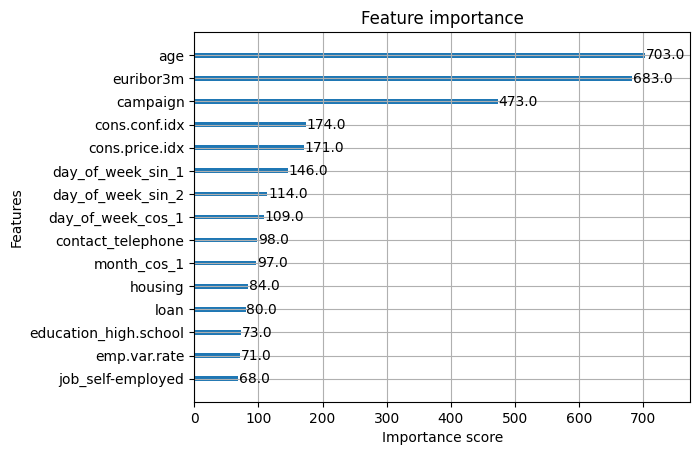

In [28]:
plot_importance(xgb_model, max_num_features=15)
plt.show()
